In [ ]:
plt.imshow(trainX[3], cmap='gray_r')

In [63]:
import cv2
import pandas as pd
import os
from matplotlib import pyplot as plt
from itertools import islice

main_path='A:/Final_Year_project/DataSet/Letter_ASL/asl_alphabet_train/asl_alphabet_train/'

df_data=pd.read_excel(main_path+'Datainfo.xlsx')




In [3]:
df_data.head()

,Unnamed: 0,path,label
0,0,A:/Final_Year_project/DataSet/Letter_ASL/asl_a...,A
1,1,A:/Final_Year_project/DataSet/Letter_ASL/asl_a...,B
2,2,A:/Final_Year_project/DataSet/Letter_ASL/asl_a...,C
3,3,A:/Final_Year_project/DataSet/Letter_ASL/asl_a...,D
4,4,A:/Final_Year_project/DataSet/Letter_ASL/asl_a...,del


In [4]:
train_labels=[]
train_imgs=[]

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=main_path,
    target_size=(128, 128),
    batch_size=256,
    class_mode="sparse",
    shuffle=True,
)

Found 87000 images belonging to 29 classes.


In [58]:
def load_imgs():
    batch=train_generator.next()
    train_imgs,train_labels=batch
    print(f"Class labels shape = {train_labels.shape}")
    return train_imgs,train_labels
    
train_imgs,train_labels=load_imgs()

Class labels shape = (256,)


TypeError: Invalid shape (128, 128, 1) for image data

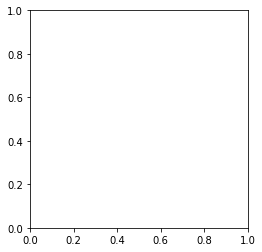

In [59]:
plt.imshow(train_imgs[97],cmap='gray')
print(f"Class label associated = {train_labels[99]}")
print(f" image shape = {train_imgs.shape}")
print(f"Class labels shape = {train_labels.shape}")

In [57]:
print(f"Train_imgs type = {type(train_imgs)}")

Train_imgs type = <class 'numpy.ndarray'>


In [9]:
print(f"Train_labels type = {type(train_labels)}")

Train_labels type = <class 'numpy.ndarray'>


In [10]:
test_imgs=[]
test_labels=[]

In [87]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate

# define the standalone discriminator model
def define_discriminator(in_shape=(128,128,3), n_classes=28):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes+1, 129)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
    
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
    
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
    
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)

	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.3)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
# define the standalone generator model
def define_generator(latent_dim, n_classes=28):
	# label input
	in_label = Input(shape=(1,))

	# embedding for categorical input
	li = Embedding(n_classes+1, 129)(in_label)

	# linear multiplication
	n_nodes = 8*8
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((8,8, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 64 * 8 * 8
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 64))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
    
	gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
    
	gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)
	print(out_layer.shape)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy)= load_imgs()
	# expand to 3d, e.g. add channels
	X=trainX
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))   
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=28):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=60, n_batch=4):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)            
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
print("Descriminator summary")
print(d_model.summary())
# create the generator
g_model = define_generator(latent_dim)
print(f"Generator summary")
print(g_model.summary())
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Descriminator summary
Model: "model_74"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_101 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_50 (Embedding)        (None, 1, 129)       3741        input_101[0][0]                  
__________________________________________________________________________________________________
dense_100 (Dense)               (None, 1, 16384)     2129920     embedding_50[0][0]               
__________________________________________________________________________________________________
input_102 (InputLayer)          [(None, 128, 128, 3) 0                                            
_____________________________________________________________________

>1, 12/64, d1=0.020, d2=0.557 g=0.992
>1, 13/64, d1=0.027, d2=0.499 g=1.128
>1, 14/64, d1=0.008, d2=0.394 g=1.481
>1, 15/64, d1=0.078, d2=0.388 g=1.347
>1, 16/64, d1=0.000, d2=0.398 g=1.769
>1, 17/64, d1=0.000, d2=0.172 g=2.526
>1, 18/64, d1=0.034, d2=0.147 g=2.334
>1, 19/64, d1=0.000, d2=0.163 g=3.167
>1, 20/64, d1=0.001, d2=0.035 g=4.092
>1, 21/64, d1=0.151, d2=0.303 g=1.542
>1, 22/64, d1=0.000, d2=0.975 g=3.210
>1, 23/64, d1=0.000, d2=0.026 g=4.810
>1, 24/64, d1=0.000, d2=0.013 g=4.783
>1, 25/64, d1=0.002, d2=0.020 g=4.331
>1, 26/64, d1=0.008, d2=0.041 g=3.904
>1, 27/64, d1=0.022, d2=0.312 g=9.421
>1, 28/64, d1=11.221, d2=3.456 g=0.044
>1, 29/64, d1=0.000, d2=2.364 g=0.429
>1, 30/64, d1=0.001, d2=0.927 g=1.310
>1, 31/64, d1=0.045, d2=0.426 g=2.058
>1, 32/64, d1=0.257, d2=0.241 g=1.991
>1, 33/64, d1=0.232, d2=0.422 g=1.648
>1, 34/64, d1=0.213, d2=0.698 g=2.053
>1, 35/64, d1=0.658, d2=1.281 g=1.279
>1, 36/64, d1=0.395, d2=0.880 g=1.711
>1, 37/64, d1=0.937, d2=1.127 g=0.790
>1, 38/64, 

>4, 37/64, d1=0.703, d2=0.747 g=0.654
>4, 38/64, d1=0.754, d2=0.662 g=0.694
>4, 39/64, d1=0.705, d2=0.675 g=0.664
>4, 40/64, d1=0.671, d2=0.760 g=0.749
>4, 41/64, d1=0.747, d2=0.751 g=0.653
>4, 42/64, d1=0.680, d2=0.660 g=0.708
>4, 43/64, d1=0.601, d2=0.748 g=0.707
>4, 44/64, d1=0.698, d2=0.661 g=0.736
>4, 45/64, d1=0.679, d2=0.716 g=0.687
>4, 46/64, d1=0.719, d2=0.703 g=0.661
>4, 47/64, d1=0.727, d2=0.640 g=0.687
>4, 48/64, d1=0.677, d2=0.700 g=0.700
>4, 49/64, d1=0.664, d2=0.712 g=0.739
>4, 50/64, d1=0.694, d2=0.692 g=0.744
>4, 51/64, d1=0.727, d2=0.751 g=0.649
>4, 52/64, d1=0.737, d2=0.714 g=0.786
>4, 53/64, d1=0.684, d2=0.701 g=0.722
>4, 54/64, d1=0.694, d2=0.757 g=0.724
>4, 55/64, d1=0.681, d2=0.679 g=0.742
>4, 56/64, d1=0.742, d2=0.723 g=0.730
>4, 57/64, d1=0.609, d2=0.694 g=0.707
>4, 58/64, d1=0.686, d2=0.756 g=0.687
>4, 59/64, d1=0.648, d2=0.709 g=0.733
>4, 60/64, d1=0.704, d2=0.681 g=0.730
>4, 61/64, d1=0.705, d2=0.734 g=0.764
>4, 62/64, d1=0.719, d2=0.673 g=0.712
>4, 63/64, d

>7, 62/64, d1=0.705, d2=0.745 g=0.687
>7, 63/64, d1=0.658, d2=0.761 g=0.697
>7, 64/64, d1=0.645, d2=0.614 g=0.690
>8, 1/64, d1=0.746, d2=0.656 g=0.689
>8, 2/64, d1=0.740, d2=0.700 g=0.648
>8, 3/64, d1=0.728, d2=0.715 g=0.663
>8, 4/64, d1=0.675, d2=0.704 g=0.684
>8, 5/64, d1=0.652, d2=0.705 g=0.713
>8, 6/64, d1=0.769, d2=0.714 g=0.747
>8, 7/64, d1=0.654, d2=0.710 g=0.664
>8, 8/64, d1=0.681, d2=0.681 g=0.667
>8, 9/64, d1=0.691, d2=0.656 g=0.714
>8, 10/64, d1=0.692, d2=0.668 g=0.680
>8, 11/64, d1=0.604, d2=0.767 g=0.650
>8, 12/64, d1=0.751, d2=0.728 g=0.812
>8, 13/64, d1=0.654, d2=0.670 g=0.789
>8, 14/64, d1=0.612, d2=0.693 g=0.762
>8, 15/64, d1=0.749, d2=0.725 g=0.690
>8, 16/64, d1=0.595, d2=0.627 g=0.733
>8, 17/64, d1=0.726, d2=0.570 g=0.679
>8, 18/64, d1=0.603, d2=0.632 g=0.745
>8, 19/64, d1=0.506, d2=0.529 g=0.821
>8, 20/64, d1=0.673, d2=0.615 g=0.754
>8, 21/64, d1=0.708, d2=0.488 g=0.765
>8, 22/64, d1=0.754, d2=0.692 g=0.855
>8, 23/64, d1=0.719, d2=0.713 g=0.617
>8, 24/64, d1=0.479, 

>11, 22/64, d1=0.840, d2=0.796 g=0.813
>11, 23/64, d1=0.677, d2=0.634 g=0.796
>11, 24/64, d1=0.784, d2=0.687 g=0.721
>11, 25/64, d1=0.763, d2=0.639 g=0.710
>11, 26/64, d1=0.718, d2=0.701 g=0.705
>11, 27/64, d1=0.746, d2=0.652 g=0.660
>11, 28/64, d1=0.608, d2=0.826 g=0.734
>11, 29/64, d1=0.664, d2=0.588 g=0.717
>11, 30/64, d1=0.713, d2=0.707 g=0.707
>11, 31/64, d1=0.653, d2=0.719 g=0.718
>11, 32/64, d1=0.642, d2=0.596 g=0.846
>11, 33/64, d1=0.700, d2=0.592 g=0.610
>11, 34/64, d1=0.664, d2=0.623 g=0.827
>11, 35/64, d1=0.825, d2=0.731 g=0.804
>11, 36/64, d1=0.711, d2=0.763 g=0.663
>11, 37/64, d1=0.665, d2=0.641 g=0.697
>11, 38/64, d1=0.603, d2=0.746 g=0.756
>11, 39/64, d1=0.698, d2=0.697 g=0.663
>11, 40/64, d1=0.661, d2=0.650 g=0.721
>11, 41/64, d1=0.672, d2=0.787 g=0.707
>11, 42/64, d1=0.710, d2=0.571 g=0.746
>11, 43/64, d1=0.582, d2=0.626 g=0.671
>11, 44/64, d1=0.670, d2=0.765 g=0.701
>11, 45/64, d1=0.536, d2=0.556 g=0.631
>11, 46/64, d1=0.759, d2=0.491 g=0.726
>11, 47/64, d1=0.661, d2=

>14, 42/64, d1=1.028, d2=0.810 g=0.736
>14, 43/64, d1=0.678, d2=0.507 g=0.617
>14, 44/64, d1=0.633, d2=0.694 g=0.942
>14, 45/64, d1=0.730, d2=0.671 g=0.713
>14, 46/64, d1=0.659, d2=0.671 g=0.627
>14, 47/64, d1=0.392, d2=0.650 g=0.942
>14, 48/64, d1=0.407, d2=0.782 g=0.654
>14, 49/64, d1=0.762, d2=1.024 g=0.690
>14, 50/64, d1=0.850, d2=0.708 g=0.923
>14, 51/64, d1=0.598, d2=0.675 g=0.742
>14, 52/64, d1=0.590, d2=0.425 g=0.879
>14, 53/64, d1=0.616, d2=0.833 g=0.826
>14, 54/64, d1=0.731, d2=0.638 g=0.669
>14, 55/64, d1=0.652, d2=0.792 g=0.702
>14, 56/64, d1=0.833, d2=0.623 g=0.699
>14, 57/64, d1=0.623, d2=0.697 g=0.683
>14, 58/64, d1=0.791, d2=0.703 g=0.781
>14, 59/64, d1=0.665, d2=0.767 g=0.732
>14, 60/64, d1=0.704, d2=0.796 g=0.692
>14, 61/64, d1=0.607, d2=0.715 g=0.728
>14, 62/64, d1=0.682, d2=0.689 g=0.660
>14, 63/64, d1=0.477, d2=0.727 g=0.712
>14, 64/64, d1=0.703, d2=0.656 g=0.656
>15, 1/64, d1=0.725, d2=0.635 g=0.617
>15, 2/64, d1=0.736, d2=0.598 g=0.708
>15, 3/64, d1=0.645, d2=0.6

>17, 61/64, d1=0.721, d2=0.641 g=0.742
>17, 62/64, d1=0.675, d2=0.772 g=0.754
>17, 63/64, d1=0.770, d2=0.665 g=0.726
>17, 64/64, d1=0.762, d2=0.703 g=0.845
>18, 1/64, d1=0.752, d2=0.615 g=0.744
>18, 2/64, d1=0.696, d2=0.710 g=0.756
>18, 3/64, d1=0.742, d2=0.647 g=0.682
>18, 4/64, d1=0.698, d2=0.745 g=0.750
>18, 5/64, d1=0.789, d2=0.658 g=0.684
>18, 6/64, d1=0.405, d2=0.663 g=0.705
>18, 7/64, d1=0.412, d2=0.660 g=0.751
>18, 8/64, d1=0.352, d2=0.717 g=0.934
>18, 9/64, d1=0.737, d2=0.632 g=0.765
>18, 10/64, d1=0.730, d2=0.724 g=0.638
>18, 11/64, d1=0.309, d2=0.651 g=0.690
>18, 12/64, d1=0.293, d2=0.576 g=0.824
>18, 13/64, d1=0.717, d2=0.717 g=0.816
>18, 14/64, d1=1.213, d2=0.511 g=0.890
>18, 15/64, d1=0.840, d2=0.700 g=0.703
>18, 16/64, d1=0.802, d2=0.735 g=0.736
>18, 17/64, d1=0.795, d2=0.662 g=0.704
>18, 18/64, d1=0.473, d2=0.643 g=0.751
>18, 19/64, d1=0.422, d2=0.729 g=0.758
>18, 20/64, d1=0.745, d2=0.689 g=0.926
>18, 21/64, d1=0.688, d2=0.664 g=0.746
>18, 22/64, d1=0.783, d2=0.661 g=0

>21, 16/64, d1=0.729, d2=0.717 g=0.744
>21, 17/64, d1=0.443, d2=0.710 g=0.842
>21, 18/64, d1=0.690, d2=0.684 g=0.773
>21, 19/64, d1=0.724, d2=0.684 g=0.688
>21, 20/64, d1=0.637, d2=0.657 g=0.694
>21, 21/64, d1=0.762, d2=0.718 g=0.705
>21, 22/64, d1=0.658, d2=0.682 g=0.657
>21, 23/64, d1=0.688, d2=0.687 g=0.729
>21, 24/64, d1=0.781, d2=0.640 g=0.683
>21, 25/64, d1=0.748, d2=0.670 g=0.701
>21, 26/64, d1=0.710, d2=0.660 g=0.667
>21, 27/64, d1=0.719, d2=0.684 g=0.712
>21, 28/64, d1=0.691, d2=0.706 g=0.673
>21, 29/64, d1=0.664, d2=0.520 g=0.676
>21, 30/64, d1=0.779, d2=0.724 g=0.718
>21, 31/64, d1=0.614, d2=0.640 g=0.736
>21, 32/64, d1=1.008, d2=0.681 g=0.695
>21, 33/64, d1=0.440, d2=0.681 g=0.702
>21, 34/64, d1=0.660, d2=0.632 g=0.820
>21, 35/64, d1=0.687, d2=0.641 g=0.723
>21, 36/64, d1=0.708, d2=0.707 g=0.703
>21, 37/64, d1=0.604, d2=0.645 g=0.689
>21, 38/64, d1=0.684, d2=0.681 g=0.712
>21, 39/64, d1=0.983, d2=0.538 g=0.681
>21, 40/64, d1=0.596, d2=0.653 g=0.618
>21, 41/64, d1=0.734, d2=

>24, 35/64, d1=0.702, d2=0.632 g=0.696
>24, 36/64, d1=0.698, d2=0.745 g=0.625
>24, 37/64, d1=0.755, d2=0.655 g=0.743
>24, 38/64, d1=0.690, d2=0.699 g=0.895
>24, 39/64, d1=0.869, d2=0.695 g=0.796
>24, 40/64, d1=0.705, d2=0.710 g=0.686
>24, 41/64, d1=0.745, d2=0.731 g=0.729
>24, 42/64, d1=0.729, d2=0.641 g=0.665
>24, 43/64, d1=0.378, d2=0.718 g=0.682
>24, 44/64, d1=0.755, d2=0.657 g=0.695
>24, 45/64, d1=0.673, d2=0.663 g=0.802
>24, 46/64, d1=0.706, d2=0.649 g=0.668
>24, 47/64, d1=0.752, d2=0.639 g=0.689
>24, 48/64, d1=0.690, d2=0.672 g=0.699
>24, 49/64, d1=0.746, d2=0.615 g=0.701
>24, 50/64, d1=0.651, d2=0.712 g=0.704
>24, 51/64, d1=0.798, d2=0.706 g=0.712
>24, 52/64, d1=0.691, d2=0.687 g=0.728
>24, 53/64, d1=0.625, d2=0.751 g=0.775
>24, 54/64, d1=0.641, d2=0.674 g=0.760
>24, 55/64, d1=0.639, d2=0.698 g=0.718
>24, 56/64, d1=0.644, d2=0.684 g=0.863
>24, 57/64, d1=0.761, d2=0.671 g=0.701
>24, 58/64, d1=0.783, d2=0.661 g=0.850
>24, 59/64, d1=0.765, d2=0.766 g=0.712
>24, 60/64, d1=0.759, d2=

>27, 54/64, d1=0.795, d2=0.619 g=0.685
>27, 55/64, d1=0.635, d2=0.742 g=0.942
>27, 56/64, d1=0.809, d2=0.821 g=0.704
>27, 57/64, d1=0.664, d2=0.653 g=0.721
>27, 58/64, d1=0.702, d2=0.569 g=0.655
>27, 59/64, d1=0.690, d2=0.774 g=0.841
>27, 60/64, d1=0.367, d2=0.699 g=0.754
>27, 61/64, d1=0.667, d2=0.629 g=0.772
>27, 62/64, d1=0.840, d2=0.544 g=0.746
>27, 63/64, d1=0.623, d2=0.719 g=0.745
>27, 64/64, d1=0.554, d2=0.735 g=0.681
>28, 1/64, d1=1.009, d2=0.737 g=0.775
>28, 2/64, d1=0.731, d2=0.787 g=0.706
>28, 3/64, d1=0.780, d2=0.675 g=0.743
>28, 4/64, d1=0.744, d2=0.702 g=0.772
>28, 5/64, d1=0.636, d2=0.673 g=0.744
>28, 6/64, d1=0.658, d2=0.599 g=0.632
>28, 7/64, d1=0.777, d2=0.716 g=0.758
>28, 8/64, d1=0.607, d2=0.551 g=0.700
>28, 9/64, d1=0.898, d2=0.667 g=0.750
>28, 10/64, d1=0.633, d2=0.780 g=0.735
>28, 11/64, d1=0.665, d2=0.413 g=0.789
>28, 12/64, d1=0.725, d2=0.690 g=0.679
>28, 13/64, d1=0.632, d2=0.830 g=0.909
>28, 14/64, d1=0.620, d2=0.676 g=0.805
>28, 15/64, d1=0.723, d2=0.739 g=0

>31, 10/64, d1=0.756, d2=0.740 g=0.696
>31, 11/64, d1=0.629, d2=0.662 g=0.694
>31, 12/64, d1=0.748, d2=0.678 g=0.716
>31, 13/64, d1=0.770, d2=0.715 g=0.735
>31, 14/64, d1=0.710, d2=0.728 g=0.709
>31, 15/64, d1=0.738, d2=0.641 g=0.714
>31, 16/64, d1=0.708, d2=0.680 g=0.727
>31, 17/64, d1=0.706, d2=0.711 g=0.676
>31, 18/64, d1=0.687, d2=0.664 g=0.733
>31, 19/64, d1=0.765, d2=0.657 g=0.692
>31, 20/64, d1=0.688, d2=0.677 g=0.673
>31, 21/64, d1=0.661, d2=0.677 g=0.691
>31, 22/64, d1=0.660, d2=0.677 g=0.667
>31, 23/64, d1=0.736, d2=0.670 g=0.749
>31, 24/64, d1=0.693, d2=0.673 g=0.698
>31, 25/64, d1=0.669, d2=0.736 g=0.742
>31, 26/64, d1=0.712, d2=0.706 g=0.702
>31, 27/64, d1=0.674, d2=0.736 g=0.682
>31, 28/64, d1=0.708, d2=0.714 g=0.697
>31, 29/64, d1=0.686, d2=0.634 g=0.693
>31, 30/64, d1=0.667, d2=0.674 g=0.675
>31, 31/64, d1=0.361, d2=0.646 g=0.675
>31, 32/64, d1=0.691, d2=0.696 g=0.720
>31, 33/64, d1=0.661, d2=0.668 g=0.754
>31, 34/64, d1=0.645, d2=0.670 g=0.689
>31, 35/64, d1=0.647, d2=

>34, 29/64, d1=0.687, d2=0.668 g=0.774
>34, 30/64, d1=0.689, d2=0.627 g=0.695
>34, 31/64, d1=0.729, d2=0.769 g=0.739
>34, 32/64, d1=0.707, d2=0.627 g=0.753
>34, 33/64, d1=0.782, d2=0.667 g=0.724
>34, 34/64, d1=0.753, d2=0.711 g=0.719
>34, 35/64, d1=0.712, d2=0.721 g=0.740
>34, 36/64, d1=0.737, d2=0.688 g=0.715
>34, 37/64, d1=0.718, d2=0.651 g=0.694
>34, 38/64, d1=0.657, d2=0.699 g=0.725
>34, 39/64, d1=0.754, d2=0.697 g=0.786
>34, 40/64, d1=0.734, d2=0.673 g=0.722
>34, 41/64, d1=0.704, d2=0.693 g=0.723
>34, 42/64, d1=0.737, d2=0.702 g=0.695
>34, 43/64, d1=0.679, d2=0.666 g=0.690
>34, 44/64, d1=0.385, d2=0.732 g=0.744
>34, 45/64, d1=0.719, d2=0.658 g=0.724
>34, 46/64, d1=0.692, d2=0.612 g=0.713
>34, 47/64, d1=0.699, d2=0.655 g=0.698
>34, 48/64, d1=0.723, d2=0.681 g=0.700
>34, 49/64, d1=0.685, d2=0.673 g=0.672
>34, 50/64, d1=0.713, d2=0.659 g=0.684
>34, 51/64, d1=0.620, d2=0.711 g=0.729
>34, 52/64, d1=0.560, d2=0.570 g=0.686
>34, 53/64, d1=1.045, d2=0.870 g=0.734
>34, 54/64, d1=0.639, d2=

>37, 48/64, d1=0.624, d2=0.729 g=0.738
>37, 49/64, d1=0.676, d2=0.778 g=0.660
>37, 50/64, d1=0.637, d2=0.491 g=0.665
>37, 51/64, d1=0.689, d2=0.671 g=0.700
>37, 52/64, d1=0.705, d2=0.698 g=0.757
>37, 53/64, d1=0.710, d2=0.868 g=0.701
>37, 54/64, d1=0.776, d2=0.753 g=0.687
>37, 55/64, d1=0.708, d2=0.707 g=0.723
>37, 56/64, d1=0.616, d2=0.763 g=0.693
>37, 57/64, d1=0.686, d2=0.673 g=0.707
>37, 58/64, d1=0.354, d2=0.722 g=0.713
>37, 59/64, d1=0.623, d2=0.656 g=0.731
>37, 60/64, d1=0.746, d2=0.657 g=0.675
>37, 61/64, d1=0.612, d2=0.687 g=0.647
>37, 62/64, d1=0.684, d2=0.640 g=0.748
>37, 63/64, d1=0.631, d2=0.670 g=0.833
>37, 64/64, d1=0.676, d2=0.706 g=0.654
>38, 1/64, d1=0.368, d2=0.649 g=0.838
>38, 2/64, d1=0.455, d2=0.507 g=0.774
>38, 3/64, d1=0.666, d2=0.793 g=0.709
>38, 4/64, d1=0.630, d2=0.470 g=0.760
>38, 5/64, d1=0.614, d2=0.680 g=0.752
>38, 6/64, d1=0.552, d2=0.612 g=1.300
>38, 7/64, d1=0.526, d2=0.241 g=1.248
>38, 8/64, d1=0.065, d2=0.536 g=1.317
>38, 9/64, d1=0.688, d2=0.549 g=0

>41, 4/64, d1=0.651, d2=0.703 g=0.733
>41, 5/64, d1=0.718, d2=0.740 g=0.686
>41, 6/64, d1=0.641, d2=0.730 g=0.733
>41, 7/64, d1=0.654, d2=0.718 g=0.725
>41, 8/64, d1=0.746, d2=0.654 g=0.827
>41, 9/64, d1=0.690, d2=0.556 g=0.691
>41, 10/64, d1=0.708, d2=0.488 g=0.742
>41, 11/64, d1=0.654, d2=0.648 g=0.920
>41, 12/64, d1=0.688, d2=0.633 g=0.728
>41, 13/64, d1=0.700, d2=0.664 g=0.885
>41, 14/64, d1=0.695, d2=0.676 g=0.950
>41, 15/64, d1=0.738, d2=0.748 g=0.684
>41, 16/64, d1=0.617, d2=0.662 g=0.685
>41, 17/64, d1=0.719, d2=0.441 g=0.922
>41, 18/64, d1=0.610, d2=0.748 g=0.642
>41, 19/64, d1=0.635, d2=0.740 g=0.683
>41, 20/64, d1=0.762, d2=0.730 g=0.659
>41, 21/64, d1=0.645, d2=0.660 g=0.790
>41, 22/64, d1=0.698, d2=0.680 g=0.894
>41, 23/64, d1=0.671, d2=0.767 g=0.763
>41, 24/64, d1=0.559, d2=0.696 g=1.034
>41, 25/64, d1=0.803, d2=0.642 g=0.993
>41, 26/64, d1=0.808, d2=0.625 g=0.699
>41, 27/64, d1=0.619, d2=0.682 g=0.634
>41, 28/64, d1=0.865, d2=0.693 g=0.749
>41, 29/64, d1=0.336, d2=0.590 

>44, 23/64, d1=0.837, d2=0.767 g=0.803
>44, 24/64, d1=0.568, d2=0.480 g=0.638
>44, 25/64, d1=0.562, d2=0.720 g=0.601
>44, 26/64, d1=0.662, d2=0.655 g=0.775
>44, 27/64, d1=0.779, d2=0.748 g=1.155
>44, 28/64, d1=0.664, d2=0.745 g=0.805
>44, 29/64, d1=0.639, d2=0.737 g=0.666
>44, 30/64, d1=0.625, d2=0.637 g=0.798
>44, 31/64, d1=0.253, d2=0.569 g=0.555
>44, 32/64, d1=0.581, d2=0.527 g=0.826
>44, 33/64, d1=0.723, d2=0.778 g=0.904
>44, 34/64, d1=0.427, d2=0.538 g=0.963
>44, 35/64, d1=1.257, d2=0.363 g=0.522
>44, 36/64, d1=0.954, d2=0.680 g=1.152
>44, 37/64, d1=0.968, d2=0.622 g=0.787
>44, 38/64, d1=0.679, d2=0.730 g=1.008
>44, 39/64, d1=0.562, d2=0.857 g=0.952
>44, 40/64, d1=0.738, d2=0.754 g=0.668
>44, 41/64, d1=0.887, d2=0.712 g=0.750
>44, 42/64, d1=0.656, d2=0.641 g=0.796
>44, 43/64, d1=0.671, d2=0.708 g=0.680
>44, 44/64, d1=0.620, d2=0.818 g=0.759
>44, 45/64, d1=0.608, d2=0.730 g=0.698
>44, 46/64, d1=0.751, d2=0.792 g=0.679
>44, 47/64, d1=0.795, d2=0.705 g=0.886
>44, 48/64, d1=0.671, d2=

>47, 44/64, d1=0.741, d2=0.676 g=0.690
>47, 45/64, d1=0.659, d2=0.671 g=0.667
>47, 46/64, d1=0.751, d2=0.545 g=0.678
>47, 47/64, d1=0.717, d2=0.645 g=0.643
>47, 48/64, d1=0.653, d2=0.658 g=0.942
>47, 49/64, d1=0.923, d2=0.738 g=0.795
>47, 50/64, d1=0.792, d2=0.711 g=0.719
>47, 51/64, d1=0.726, d2=0.691 g=0.746
>47, 52/64, d1=0.701, d2=0.665 g=0.761
>47, 53/64, d1=0.679, d2=0.650 g=0.700
>47, 54/64, d1=0.656, d2=0.699 g=0.676
>47, 55/64, d1=0.694, d2=0.656 g=0.712
>47, 56/64, d1=0.687, d2=0.664 g=0.710
>47, 57/64, d1=0.673, d2=0.607 g=0.689
>47, 58/64, d1=0.776, d2=0.555 g=0.752
>47, 59/64, d1=0.660, d2=0.664 g=0.719
>47, 60/64, d1=0.658, d2=0.681 g=0.721
>47, 61/64, d1=0.603, d2=0.581 g=0.735
>47, 62/64, d1=0.693, d2=0.703 g=0.829
>47, 63/64, d1=0.811, d2=0.780 g=0.674
>47, 64/64, d1=0.818, d2=0.785 g=0.765
>48, 1/64, d1=0.385, d2=0.709 g=0.757
>48, 2/64, d1=0.700, d2=0.741 g=0.735
>48, 3/64, d1=0.717, d2=0.672 g=0.691
>48, 4/64, d1=0.785, d2=0.647 g=0.724
>48, 5/64, d1=0.731, d2=0.651

>50, 64/64, d1=0.591, d2=0.707 g=0.708
>51, 1/64, d1=0.712, d2=0.718 g=0.681
>51, 2/64, d1=0.804, d2=0.680 g=0.679
>51, 3/64, d1=0.685, d2=0.750 g=0.813
>51, 4/64, d1=0.762, d2=0.652 g=0.718
>51, 5/64, d1=0.713, d2=0.589 g=0.661
>51, 6/64, d1=0.708, d2=0.686 g=0.671
>51, 7/64, d1=0.646, d2=0.658 g=0.718
>51, 8/64, d1=0.721, d2=0.669 g=0.680
>51, 9/64, d1=0.705, d2=0.630 g=0.736
>51, 10/64, d1=0.735, d2=0.520 g=0.666
>51, 11/64, d1=0.699, d2=0.821 g=0.688
>51, 12/64, d1=0.615, d2=0.663 g=0.716
>51, 13/64, d1=0.625, d2=0.567 g=0.692
>51, 14/64, d1=0.746, d2=0.666 g=0.717
>51, 15/64, d1=0.701, d2=0.695 g=0.869
>51, 16/64, d1=0.701, d2=0.721 g=0.686
>51, 17/64, d1=0.651, d2=0.672 g=0.704
>51, 18/64, d1=0.677, d2=0.732 g=0.629
>51, 19/64, d1=0.705, d2=0.741 g=0.733
>51, 20/64, d1=0.617, d2=0.668 g=0.746
>51, 21/64, d1=0.742, d2=0.643 g=0.663
>51, 22/64, d1=0.630, d2=0.613 g=0.721
>51, 23/64, d1=0.797, d2=0.596 g=0.763
>51, 24/64, d1=0.677, d2=0.808 g=0.633
>51, 25/64, d1=0.768, d2=0.675 g=0

>54, 20/64, d1=0.750, d2=0.554 g=0.689
>54, 21/64, d1=0.702, d2=0.660 g=0.826
>54, 22/64, d1=0.704, d2=0.689 g=0.694
>54, 23/64, d1=0.648, d2=0.626 g=0.724
>54, 24/64, d1=0.614, d2=0.610 g=0.818
>54, 25/64, d1=0.677, d2=0.581 g=0.669
>54, 26/64, d1=0.919, d2=0.650 g=0.743
>54, 27/64, d1=0.585, d2=0.763 g=0.733
>54, 28/64, d1=0.740, d2=0.578 g=0.667
>54, 29/64, d1=0.635, d2=0.717 g=0.660
>54, 30/64, d1=0.664, d2=0.713 g=0.759
>54, 31/64, d1=0.396, d2=0.720 g=0.707
>54, 32/64, d1=0.718, d2=0.682 g=0.714
>54, 33/64, d1=0.646, d2=0.702 g=0.745
>54, 34/64, d1=0.957, d2=0.665 g=0.719
>54, 35/64, d1=0.724, d2=0.696 g=0.692
>54, 36/64, d1=0.710, d2=0.635 g=0.688
>54, 37/64, d1=0.711, d2=0.679 g=0.680
>54, 38/64, d1=0.655, d2=0.699 g=0.750
>54, 39/64, d1=0.713, d2=0.639 g=0.697
>54, 40/64, d1=0.768, d2=0.720 g=0.722
>54, 41/64, d1=0.656, d2=0.762 g=0.681
>54, 42/64, d1=0.755, d2=0.710 g=0.717
>54, 43/64, d1=0.344, d2=0.682 g=0.668
>54, 44/64, d1=0.671, d2=0.623 g=0.718
>54, 45/64, d1=0.671, d2=

>57, 41/64, d1=0.644, d2=0.617 g=0.654
>57, 42/64, d1=0.684, d2=0.694 g=0.642
>57, 43/64, d1=0.307, d2=0.602 g=0.716
>57, 44/64, d1=0.693, d2=0.777 g=0.675
>57, 45/64, d1=0.894, d2=0.690 g=0.702
>57, 46/64, d1=0.669, d2=0.696 g=0.685
>57, 47/64, d1=0.595, d2=0.618 g=0.777
>57, 48/64, d1=0.716, d2=0.723 g=0.703
>57, 49/64, d1=0.703, d2=0.722 g=0.634
>57, 50/64, d1=0.693, d2=0.704 g=0.716
>57, 51/64, d1=0.607, d2=0.563 g=0.966
>57, 52/64, d1=0.638, d2=0.596 g=0.681
>57, 53/64, d1=0.824, d2=0.686 g=0.667
>57, 54/64, d1=0.804, d2=0.772 g=0.697
>57, 55/64, d1=0.641, d2=0.759 g=0.674
>57, 56/64, d1=0.747, d2=0.683 g=0.737
>57, 57/64, d1=0.679, d2=0.707 g=0.705
>57, 58/64, d1=0.692, d2=0.732 g=0.679
>57, 59/64, d1=0.673, d2=0.737 g=0.653
>57, 60/64, d1=0.669, d2=0.591 g=0.667
>57, 61/64, d1=0.710, d2=0.630 g=0.661
>57, 62/64, d1=0.768, d2=0.680 g=0.713
>57, 63/64, d1=0.717, d2=0.630 g=0.757
>57, 64/64, d1=0.704, d2=0.716 g=0.641
>58, 1/64, d1=0.788, d2=0.651 g=0.717
>58, 2/64, d1=0.776, d2=0.

>60, 60/64, d1=0.691, d2=0.602 g=0.805
>60, 61/64, d1=0.720, d2=0.622 g=0.636
>60, 62/64, d1=0.753, d2=0.560 g=0.778
>60, 63/64, d1=0.639, d2=0.782 g=0.736
>60, 64/64, d1=0.685, d2=0.799 g=0.722


In [ ]:
#print(train_imgs)

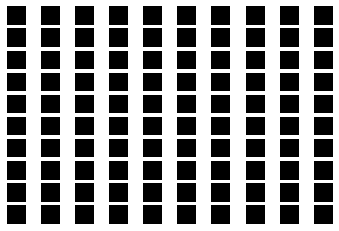

In [88]:
# example of loading the generator model and generating images
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=28):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(10, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

(100, 128, 128, 3)


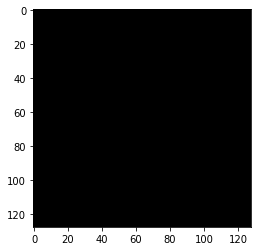

In [91]:
from matplotlib import pyplot as plt
plt.imshow(X[15, :, :])

print(X.shape)

# plt.imshow(train_imgs[1])

In [94]:
MAPS = 128
noise_dim = 128

from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal
init = RandomNormal(mean=0.0, stddev=0.02)

def make_generator():
    seed = tf.keras.Input(shape=((noise_dim,)))
    label = tf.keras.Input(shape=((1,)))
    x = layers.Embedding(120, 120, input_length=1,name='emb')(label)
    x = layers.Flatten()(x)
    x = layers.concatenate([seed,x])
    x = layers.Dense(4*4*MAPS*8, use_bias=False)(x)
    x = layers.Reshape((4, 4, MAPS*8))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(MAPS*4, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(MAPS*2, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(MAPS, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False, activation='tanh')(x)

    model = tf.keras.Model(inputs=[seed,label], outputs=x)    
    return model

generator = make_generator()

generator.summary()

Model: "model_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_106 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
emb (Embedding)                 (None, 1, 120)       14400       input_106[0][0]                  
__________________________________________________________________________________________________
input_105 (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
flatten_26 (Flatten)            (None, 120)          0           emb[0][0]                        
___________________________________________________________________________________________

In [95]:

def make_discriminator():
    image = tf.keras.Input(shape=((64,64,3)))
    label = tf.keras.Input(shape=((1,)))
    x = layers.Embedding(120, 64*64, input_length=1)(label)
    x = layers.Reshape((64,64,1))(x)
    x = layers.concatenate([image,x])
    
    x = layers.Conv2D(MAPS, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    #x = layers.GaussianNoise(GNOISE)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(MAPS*2, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    #x = layers.GaussianNoise(GNOISE)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(MAPS*4, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    #x = layers.GaussianNoise(GNOISE)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(MAPS*8, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    #x = layers.GaussianNoise(GNOISE)(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(121, activation='sigmoid')(x)
    x2 = layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs=[image,label], outputs=[x,x2])
    return model

discriminator = make_discriminator()
discriminator.summary()

Model: "model_78"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_108 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, 1, 4096)      491520      input_108[0][0]                  
__________________________________________________________________________________________________
input_107 (InputLayer)          [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
reshape_79 (Reshape)            (None, 64, 64, 1)    0           embedding_52[0][0]               
___________________________________________________________________________________________

In [96]:
EPOCHS = 250
num_examples = 16

@ tf.function
def train_step(images,generator,discriminator,generator_optimizer,discriminator_optimizer):
        
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True,label_smoothing=0.4)
    bce2 = tf.keras.losses.BinaryCrossentropy(from_logits=False,label_smoothing=0.4)
    noise = tf.random.normal((32,128)) # update noise_dim here
    labs = tf.cast(120*tf.random.uniform((32,)),tf.int32)
    
    # USE GRADIENT TAPE TO CALCULATE GRADIENTS
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:       
        generated_images = generator([noise,labs], training=True)
        real_cat, real_output = discriminator([images[0],images[1]], training=True)
        fake_cat, fake_output = discriminator([generated_images,labs], training=True)
    
        # GENERATOR LOSS 
        gen_loss = (tf.reduce_mean( (real_output - tf.reduce_mean(fake_output,0) + tf.ones_like(real_output))**2,0 )
        + tf.reduce_mean( (fake_output - tf.reduce_mean(real_output,0) - tf.ones_like(real_output))**2,0 ) )/2.
        
        # DISCRIMINATOR LOSS
        disc_loss = bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)           
        real_cat2 = tf.one_hot(tf.cast(images[1],tf.int32),121,dtype=tf.int32)
        fake_cat2 = tf.one_hot(120*tf.ones((32,),tf.int32),121,dtype=tf.int32)
        disc_loss += bce2(real_cat2,real_cat) + bce2(fake_cat2,fake_cat) 
        
    # BACK PROPAGATE ERROR
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
       
    return gen_loss, disc_loss

print('Training started. Displaying every '+str(DISPLAY_EVERY)+'th epoch.')
train(ds, EPOCHS)

NameError: name 'DISPLAY_EVERY' is not defined

In [ ]:
plt.imshow(X[4, :, :])

##### 

In [ ]:
print(X.shape)

In [ ]:
for index,row in df_data.iterrows():
    curr_path=(row[1])
    for filename in os.listdir(curr_path):
        path_name=(os.path.join(curr_path,filename))
        img=cv2.imread(path_name,0)
        print(path_name)
        if img is not None:
            dim=(112,112)
            train_imgs.append(cv2.resize(img,dim))
            train_labels.append(row[2])
    

In [ ]:

labels, levels = pd.factorize(train_labels)
train_labels=labels
print(train_labels)
            
    

In [ ]:
from numpy import asarray
import numpy as np

train_imgs=asarray(train_imgs)
test_imgs=asarray(test_imgs)
train_labels=asarray(train_labels)
test_labels=asarray(test_labels)

print('Train', train_imgs.shape, train_labels.shape)
print('Test', test_imgs.shape, test_labels.shape)

print(type(train_imgs))
from matplotlib import pyplot as plt